# EXTRACTOR Nº 2: TEXTURAS

In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import faiss
import glob
import random
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from pathlib import Path
from PIL import Image
from sklearn.preprocessing import normalize

In [2]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño objetivo
    img = img.resize(target_size)
    # Convertir la imagen en un array de numpy y normalizar (escalar píxeles a 0-1)
    img_array = np.array(img)
    return img_array

# Ruta principal donde está almacenado el dataset
dataset_path = Path("./DatasetArteTrainTest/Train")

# Creamos el DataFrame vacío
df = pd.DataFrame()

# Obtenemos todas las imágenes en cada subcarpeta
df['image'] = [str(file) for file in dataset_path.rglob('*.jpg') if file.is_file()]
df['Preprocessed_Images'] = df['image'].apply(preprocess_image)

# Verificamos las primeras filas para asegurarnos de que las rutas están correctas y que están todas las imagenes. 
print(df['image'].shape[0], ' imagenes en total.') 
df.head()

324  imagenes en total.


,image,Preprocessed_Images
0,DatasetArteTrainTest\Train\185139-Rococo.jpg,"[[[77, 63, 52], [63, 49, 38], [58, 44, 33], [5..."
1,DatasetArteTrainTest\Train\185140-Rococo.jpg,"[[[74, 59, 52], [68, 53, 46], [72, 57, 50], [7..."
2,DatasetArteTrainTest\Train\185141-Rococo.jpg,"[[[90, 66, 66], [93, 69, 69], [84, 60, 60], [8..."
3,DatasetArteTrainTest\Train\185142-Rococo.jpg,"[[[107, 90, 81], [108, 96, 83], [103, 93, 80],..."
4,DatasetArteTrainTest\Train\185143-Rococo.jpg,"[[[74, 57, 50], [78, 63, 55], [84, 71, 61], [8..."


In [3]:
img_train = np.array(df['Preprocessed_Images'].tolist())

In [4]:
def calcular_histograma_textura(imagen, distancias=[5], angulos=[45]):
    """
    Calcula un histograma basado en propiedades de textura (GLCM).
    """
    imagen_gris = rgb2gray(imagen)
    imagen_gris = (imagen_gris * 255).astype(np.uint8)

    # Calcular GLCM
    glcm = graycomatrix(imagen_gris, distances=distancias, angles=angulos, symmetric=True, normed=True)
    
    # Propiedades de textura
    propiedades = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    valores_textura = {prop: graycoprops(glcm, prop).flatten() for prop in propiedades}
    
    # Crear un histograma concatenando los valores de textura
    histograma = np.concatenate([valores_textura[prop] for prop in propiedades])
    return histograma

def preprocess_features(train_feats):
    train_feats = np.array(train_feats)
    train_feats = train_feats.reshape(train_feats.shape[0], -1)
    train_feats = train_feats.astype('float32')
    return train_feats

In [5]:
filename = 'database/feat_extract_2.index'
if not os.path.exists(filename):
    train_features = np.array(df['Preprocessed_Images'].apply(calcular_histograma_textura).tolist())
    train_features = preprocess_features(train_features)
    index = faiss.IndexFlatL2(train_features.shape[1])  # L2 distance
    index.add(train_features)  # Añadir las características al índice
    # Guardar el índice en el archivo correspondiente
    faiss.write_index(index, filename)
else:
    index = faiss.read_index(filename)


In [6]:
test_dir = "./DatasetArteTrainTest/Test/"
query_index = 0
query_image = os.path.join(test_dir, os.listdir(test_dir)[query_index])
query_image = preprocess_image(query_image)
k = 9

feature_vector_hist = calcular_histograma_textura(query_image)
feature_vector = feature_vector_hist.reshape(feature_vector_hist.shape[0], -1)
feature_vector = feature_vector.reshape(1, -1)
# Buscar en el indice los k vectores más parecidos
_, indices = index.search(feature_vector, k)
# Extraer las imágenes asociadas
nearest_images = [img_train[idx] for idx in indices[0]]

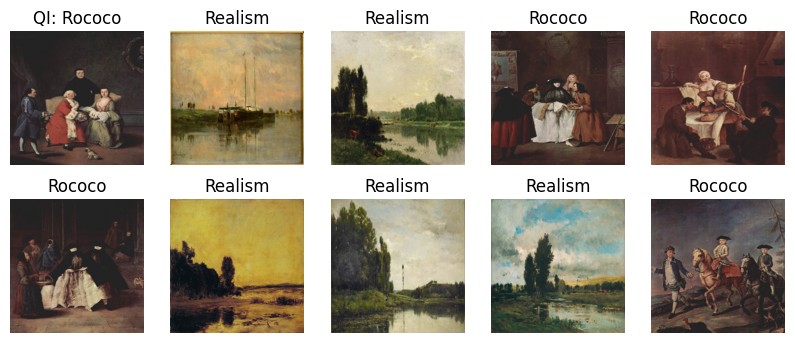

In [7]:
def show_result(similar_images, query_image):
    k = len(similar_images)

    # Crear una figura y subgráficas (subplots)
    fig, axes = plt.subplots(2, int((k + 1)/2), figsize=(10, 4))

    axes = axes.flatten()

    # Plotear la imagen de consulta
    axes[0].imshow(query_image)
    axes[0].set_title("QI: " + os.listdir(test_dir)[query_index].split('-')[1].split('.')[0])
    axes[0].axis('off')

    # Plotear las imágenes más similares
    for i, sim_img in enumerate(similar_images):
        axes[i + 1].imshow(sim_img)
        img_name = Path(df['image'][indices[0][i]]).name.split('-')[1].split('.')[0]  
        axes[i + 1].set_title(img_name)
        axes[i + 1].axis('off')

    plt.show()

show_result(nearest_images, query_image)